# Lockdown challenge

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import keras
import nltk
import gensim
from gensim.models import word2vec
import sys
import joblib
import gc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize
W2V_LOAD_FROM_FILE =True
WORD_ARRAY_LOAD_FROM_FILE =True
VERBOSE = 10


In [67]:
%matplotlib inline
sns.set()
plt.rcParams['figure.figsize'] = (12,8)
from IPython.display import IFrame, HTML, Image

In [35]:
def log(msg, level = 0):
    if VERBOSE>0:
        print(msg)
        # print('\a')

In [69]:
# IFrame('https://google.com', 100,100)
HTML('<b>asdasdad</b>')
# Image([101,11])

## Preparing the data, preprocessing/ loading the saved models

In [36]:

if WORD_ARRAY_LOAD_FROM_FILE:
    log("Loading the already tokenized words from file")
    with open('words.pkl','rb')as f:words = pickle.load(f)
else:
    log("Opening the raw tet file")
    with open('data/texts/final/en_US/en_US.twitter.txt', 'r') as f:
        txt = f.read()
    sen = nltk.sent_tokenize(txt)
    words = [nltk.word_tokenize(x) for x in sen]
    log("saving the tokenized words")
    with open('words.pkl','wb')as f:pickle.dump(words,f)


if W2V_LOAD_FROM_FILE:
    log("Loading the already trained w2v model from file")
    with open('wv_model.pkl','rb') as f: wv_model = pickle.load(f)
else:
    log("Creating the w2v model from tokens")
    wv_model = word2vec.Word2Vec(words,min_count=1)
    if True:
        log("Saving the trained w2v model to file")
        with open('wv_model.pkl', 'wb') as f:
            pickle.dump(wv_model,f)


Loading the already tokenized words from file
Loading the already trained w2v model from file


In [37]:
log("creating a data frame")
df = pd.DataFrame({'words':words})

creating a data frame


In [38]:
# log("Some visualization")
# sns.distplot(df_sample.loc[df_sample['wordlen']<100]['wordlen'], rug  =True)
# np.max(df['wordlen'])

In [39]:
def do_stuff_1(df):
    log("calculating the word length per row")
    df['wordlen'] = [len(x) for x in df['words']]
    log("calculating the bag of words vector total for each row")
    wt=[]
    for row in df['words']:
        wt.append(np.sum([wv_model.wv[word] for word in row],axis = 0))
    try:
        df['wv_total']  =wt
        df = df.reset_index()
    except:
        raise
    return df
log("Taking a sample of 100000 rows for the time being")
df_sample = df.sample(100000)
df_sample = do_stuff_1(df_sample)


Taking a sample of 100000 rows for the time being
calculating the word length per row
calculating the bag of words vector total for each row


##  Trying to visualise the total word vector (bag of words) per tweet

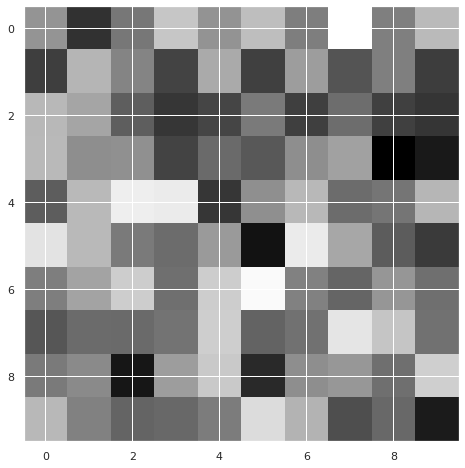

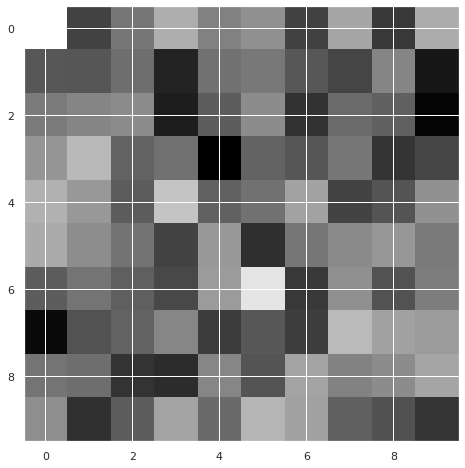

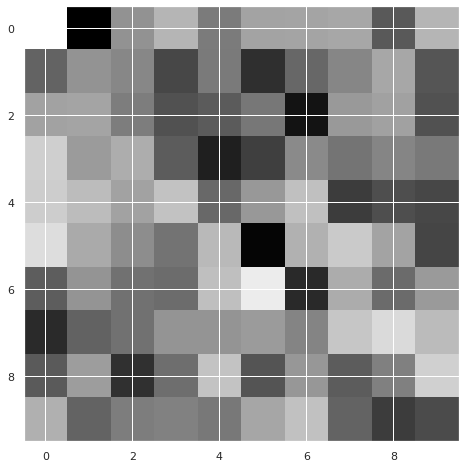

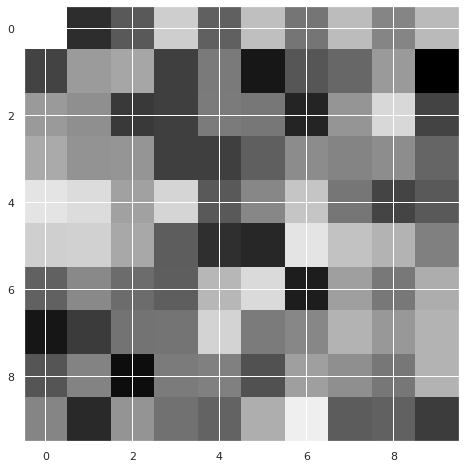

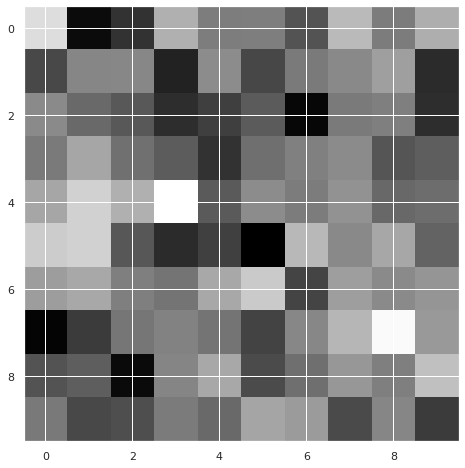

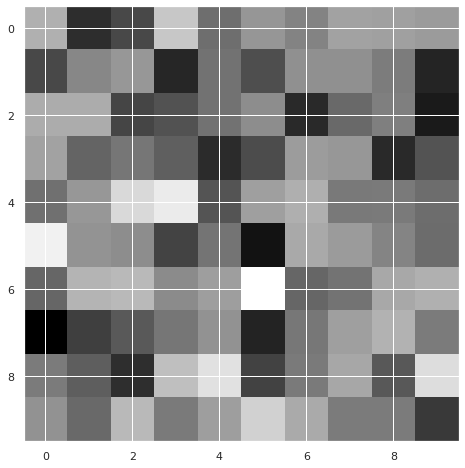

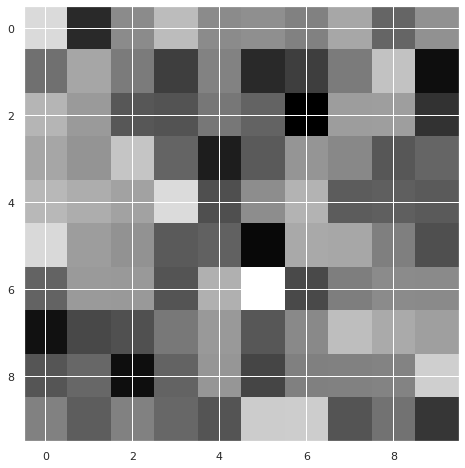

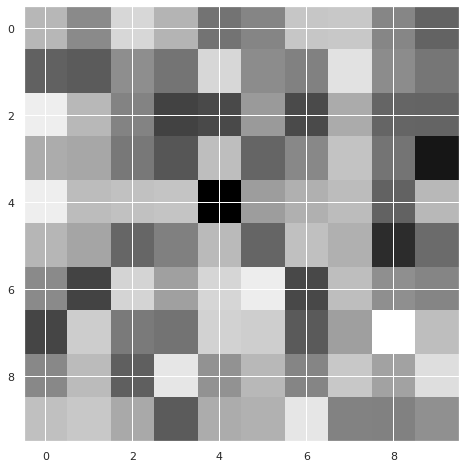

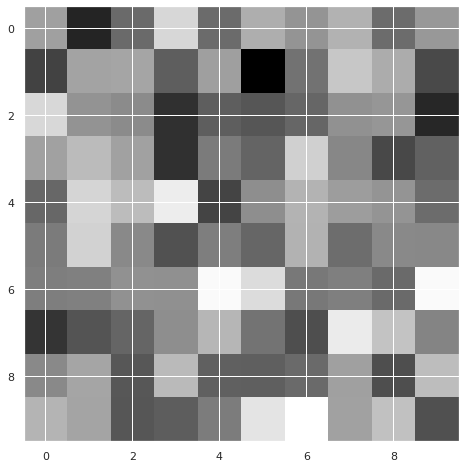

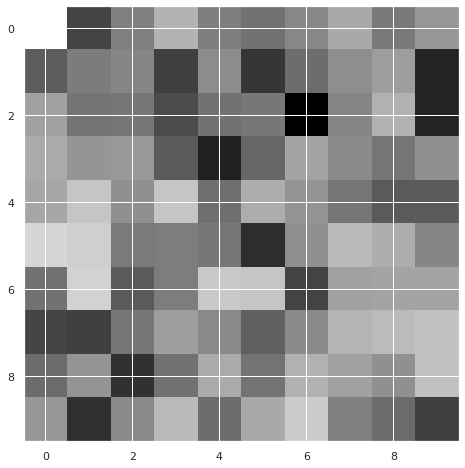

<Figure size 864x576 with 0 Axes>

In [40]:
def temp(n):
    x = df_sample['wv_total'][n]
    x = np.repeat(x,3)
    x = (x - np.min(x)) /( np.max(x)-np.min(x) )
    x = np.reshape(x,(10,10,3))
    return x
for i in range(0,10):
    plt.imshow(temp(i))
    f = plt.figure()


## Trying clustering
### (Did not work. Too diverse)


In [41]:
km = KMeans(n_clusters = 50, verbose =None, max_iter = 4000)
x = np.array(df_sample['wv_total'])
# clust = km.fit_predict(x)
x = np.array([np.array(x) for x in x])
clust = km.fit_predict(x)

In [ ]:
df_sample['clust']= clust

In [44]:
df_sample.loc[df_sample['clust']==20]  

,index,words,wordlen,wv_total,clust
120,1612507,"[``, r, u, going, to, musicfest, Coffee, and, ...",34,"[52.818504, -62.97706, -16.585897, 29.622343, ...",20
183,1450756,"[I, could, have, passed, ,, but, it, would, ha...",27,"[54.072384, -59.86375, -7.037002, 28.295506, 1...",20
189,596380,"[I, didnt, wan, na, come, back, but, my, mom, ...",36,"[88.66821, -66.74574, -0.43905765, 35.772346, ...",20
483,2764390,"[It, 's, the, way, I, ’, m, feeling, I, just, ...",33,"[67.89465, -41.572643, -5.043221, 30.588251, 2...",20
511,751103,"[I, thought, my, manager, was, outside, my, do...",34,"[43.251778, -45.39425, 1.2959641, 31.841219, 1...",20
...,...,...,...,...,...
99471,1656772,"[cause, i, have, class, again, tomorrow, morni...",44,"[76.65002, -66.4738, -3.7108192, 37.09705, -18...",20
99473,364510,"[when, you, fall, for, someone, 's, personalit...",36,"[65.62557, -53.281063, -1.8346626, 50.46903, -...",20
99500,384425,"[I, ca, n't, picture, this, lol, I, 'd, see, y...",35,"[86.69589, -58.98931, 0.8469716, 53.138103, 6....",20
99523,924885,"[I, heard, you, guys, got, ice, cream, tn, wis...",35,"[75.12828, -57.51458, 4.494307, 40.93998, 5.13...",20


### Trying to classify few tweets manually and then let the model take over


## Searching for the word 'football' hoping to find tweets relating to football
### findings:
    - Data is highly imbalanced.  there are only about 119 tweets witht the word 'football' out of 100,000 tweets

In [45]:
searchitems = ['football']
i = [ (lambda wrds: any([wrd in searchitems for wrd in wrds]))(lin) for lin in df_sample['words']]
df_sample['football'] = 0
df_sample.loc[np.array(i),'football']=1
df_sample.loc[df_sample['football']==1]




,index,words,wordlen,wv_total,clust,football
410,928625,"[But, I, 'm, skipping, out, on, the, Italian, ...",15,"[24.533796, -24.933243, 2.116379, 22.704792, -...",7,1
879,2063064,"[I, guess, not, all, girls, like, football, li...",11,"[37.921635, -22.077513, -0.98195606, 14.22514,...",18,1
1460,2587479,"[I, 'm, getting, rd, of, all, my, posters, and...",42,"[44.772686, -70.19609, 4.362145, 32.94586, 11....",35,1
1973,1388478,"[:, ), That, 's, the, 2nd, football, I, 've, s...",30,"[32.536297, -54.471428, 3.8574762, 29.654594, ...",9,1
2197,897038,"[Feelings, tend, to, cloud, your, judgement..,...",42,"[84.228294, -63.173492, -15.783243, 53.23744, ...",3,1
...,...,...,...,...,...,...
89739,2467724,"[Losing, sucks, but, realizing, how, great, th...",27,"[48.03213, -33.586006, -4.926985, 33.541676, 0...",39,1
89853,967373,"[HEADSHOT, I, predict, that, 75, %, of, all, o...",31,"[61.331196, -53.146996, 2.515451, 43.43781, 4....",37,1
91722,934696,"[No, cable, 2, football, Saturdays, in, a, row...",18,"[43.455605, -35.208775, -2.5842786, 10.086304,...",5,1
95737,133602,"[come, on, Blazers, not, postal, ,, but, I, wo...",18,"[49.05972, -33.645176, -0.38919568, 24.705229,...",5,1


In [46]:
temp1 = df_sample.loc[df_sample['football']==1]
temp2 = df_sample.loc[df_sample['football']==0].sample(300)
df_train = temp1.append(temp2)

In [47]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Flatten
model = Sequential()
model.add(Dense(500,activation='relu', input_shape=(100,)))
model.add(Dropout(.4))
model.add(Dense(300, activation='relu'))
model.add(Dropout(.4))
model.add(Dense(2,activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
train_x = df_train.loc[:,'wv_total']
train_x = np.array([np.array(x) for x in df_train.loc[:,'wv_total']])
train_x.shape
train_y = keras.utils.to_categorical(df_train.loc[:,'football'])
train_y.shape
h = model.fit(train_x, train_y, epochs=100,  validation_split = .2, verbose = 0)

# model.fit?

In [49]:
h.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [50]:
df_test = do_stuff_1( df.sample(100000))
df_test

test_x = np.array([np.array(x) for x in df_test.loc[:,'wv_total']])
test_x.shape

pred = model.predict(test_x)
pred = np.round(pred)

df_test['pred_football'] = np.argmax(pred,1)

# df_sample['words'][10]

calculating the word length per row
calculating the bag of words vector total for each row


In [51]:
temp = df_test.loc[df_test['pred_football']==1,'words']
temp = ['==== '+' '.join(x) for x in temp]
temp[100:200]


["==== When he wins , it 's all good .",
 "==== Wish I 'd been there for the live experience .",
 "==== knew I had a good nite last nite , when I woke up and could n't breathe.🚬😁 no that tweet creeped on me How old are you ?",
 '==== I want to watch this spiderman movie ! !',
 "==== So next sunday I think imma go see avengers who 's trynna go with Dude It Was Awesome Talking To U On Ustream Thanks For Answering I Love Pair Of Kings 300k apps , 7 billion downloads in iTunes alone ; ) Saw the Gophers volleyball team at the MKE airport last night .",
 '==== RT : Best wishes and loving concern 4 all storm victims 2day .',
 '==== See what other things I do beside faithful fish : ) Glad the # Spurs got the W but in all honesty that was a nail biting game in the beginning .',
 '==== having the worst day everr *- > BaByDoLL < -* DOTD ATL kicks off in a few !',
 '==== I was on a victorious secret kickball team last summer ! ! ! !',
 '==== God this girl tweets to much..i think I know who was tal

In [52]:
from ipywidgets import interact
@interact
def dostuff(inp = "hello", x=[1,2,3]):
    return (inp + ' ')*x


'hello '